In [1]:
from datetime import datetime
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

# 1. На основании данных рейтинга top500 спрогнозировать  производительность компьютера №1 в 2025

json-файл предоставлен Дмитрием Трофимовым в группе discord - HPC

In [2]:
with open("top500_perfomance.json") as f:
    top500_perfomance = json.load(f)
    
list(top500_perfomance.keys())[0], top500_perfomance[list(top500_perfomance.keys())[0]]

('06/1993',
 {'Sum': [1100.0, 'GFlop/s'],
  '#1': [59.7, 'GFlop/s'],
  '#500': [0.4, 'GFlop/s']})

In [3]:
date = np.array([
    datetime.strptime(k,"%m/%Y")
    for k in top500_perfomance.keys()
])

X = np.array([
    datetime.strptime(k,"%m/%Y").timestamp()
    for k in top500_perfomance.keys()
]).reshape(-1, 1)

y = np.array([
    v["#1"][0] 
    for v in top500_perfomance.values()
])

In [4]:
date[:5]

array([datetime.datetime(1993, 6, 1, 0, 0),
       datetime.datetime(1993, 11, 1, 0, 0),
       datetime.datetime(1994, 6, 1, 0, 0),
       datetime.datetime(1994, 11, 1, 0, 0),
       datetime.datetime(1995, 6, 1, 0, 0)], dtype=object)

Судя по датам выше, статистика собирается 2 раза в год: в июне и ноябре.

Построим график изменения производительности компьютера №1 в мире в логарифмической шкале в зависимости от даты

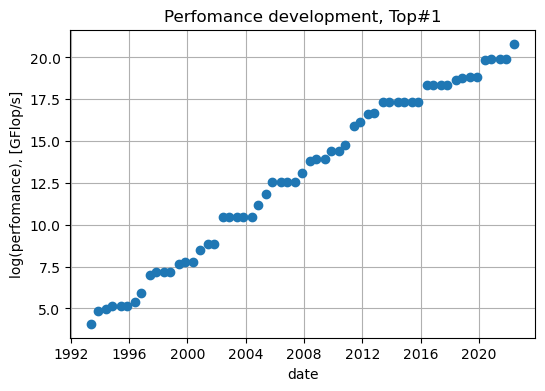

In [5]:
plt.figure(figsize=(6, 4))
plt.plot(date, np.log(y), "o")
plt.title("Perfomance development, Top#1")
plt.xlabel("date")
plt.ylabel("log(perfomance), [GFlop/s]")
plt.grid();

`Зависимость визуально четко линейная. Поэтому, не мудруствуя лукаво, воспользуемся линейной регрессией`

In [6]:
lr = LinearRegression()
lr.fit(X, np.log(y));

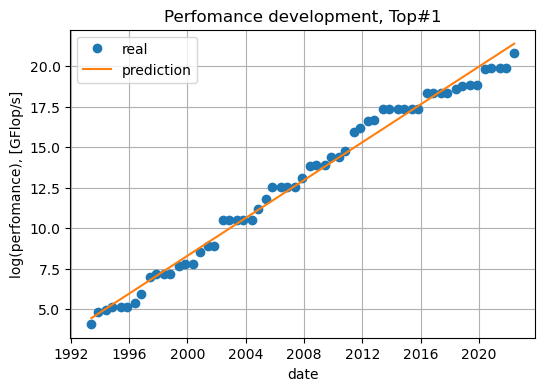

In [7]:
plt.figure(figsize=(6, 4))
plt.plot(date, np.log(y), "o", label="real")
plt.plot(date, lr.predict(X), label="prediction")
plt.title("Perfomance development, Top#1")
plt.xlabel("date")
plt.ylabel("log(perfomance), [GFlop/s]")
plt.legend()
plt.grid();

**Прогноз на 2025 год: июнь и ноябрь**

In [8]:
perfomance_2025 = np.exp(
    lr.predict(
        [
            [datetime.strptime("06/2025","%m/%Y").timestamp()], 
            [datetime.strptime("11/2025","%m/%Y").timestamp()]
        ]
    )
)

# Перевод в эксафлопсы
perfomance_2025 = perfomance_2025 * 1e9 / 1e18

In [9]:
print("Прогноз на 2025:")
print(f"* 06 / 2025: {round(perfomance_2025[0], 1)}, EFlops/s")
print(f"* 11 / 2025: {round(perfomance_2025[1], 1)}, EFlops/s")

Прогноз на 2025:
* 06 / 2025: 11.3, EFlops/s
* 11 / 2025: 14.5, EFlops/s


# Полученный прогноз на 2025 год:
* *06 / 2025*: ${\ \ \ \ }$ **11.3 EFlop/s**
* *11 / 2025*: ${\ \ \ \ }$ **14.5 EFlop/s**

# 2. Оцените какой процент всего производимого на Земле электричества потребляют все компьютеры из top500

Данные о суммарном производстве электоэнергии взяты отсюда https://ourworldindata.org/grapher/electricity-prod-source-stacked

In [10]:
# суммарное производство электроэнергии
electricity_production = 282014.07  # terawatt-hour
electricity_production *= 1e12  # watt-hour
electricity_production /= 1e3  # kilowatt-hour

In [11]:
top500 = pd.read_excel("GREEN500_202206.xlsx")
top500.head(2)

,Rank,TOP500 Rank,Name,Computer,Site,Manufacturer,Country,Year,Segment,Total Cores,...,Accelerator/Co-Processor,Cores per Socket,Processor Generation,System Model,System Family,Interconnect Family,Interconnect,Continent,Site ID,System ID
0,1,29,Frontier TDS,"HPE Cray EX235a, AMD Optimized 3rd Generation ...",DOE/SC/Oak Ridge National Laboratory,HPE,United States,2021,Research,120832,...,AMD Instinct MI250X,64,AMD Milan,HPE Cray EX235a,HPE Cray EX,Gigabit Ethernet,Slingshot-11,North America,48553,180053
1,2,1,Frontier,"HPE Cray EX235a, AMD Optimized 3rd Generation ...",DOE/SC/Oak Ridge National Laboratory,HPE,United States,2021,Research,8730112,...,AMD Instinct MI250X,64,AMD Milan,HPE Cray EX235a,HPE Cray EX,Gigabit Ethernet,Slingshot-11,North America,48553,180047


In [12]:
top500["Power (kW)"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 500 entries, 0 to 499
Series name: Power (kW)
Non-Null Count  Dtype  
--------------  -----  
191 non-null    float64
dtypes: float64(1)
memory usage: 4.0 KB


> У больше половины пропуски.
>
> Усредним тогда имеющуюся мощность и умножим на количество суперкомпьютеров - на 500.

Суммарная мощность всех суперкомпьютеров в кВт

In [13]:
power_total_consumption = top500['Power (kW)'].mean() * 500
power_total_consumption

891325.7853403143

Предполагая, что они работают целый год без остановок, суммарное потребление энергии будет находиться следующим образом:

In [14]:
electricity_consumption = power_total_consumption * 365 * 24  # кВт*ч
electricity_consumption

7808013879.581152

Найдем процент потребления:

In [15]:
rate = electricity_consumption / electricity_production * 100
print(f"{round(rate, 5)} %")

0.00277 %


# Полученный результат: ~$2,7 \cdot 10^{-3}\%$
`Как-то много даже кажется... Но это по идее, если они будут непрерывно работать. Наверное, на практике это число поменьше`

### Если выше взять медиану, а не среднее, то итоговый процент получается $1,3 \cdot 10^{-3} \%$

> **Ремарка**
>
> Еще попробовал решить последнюю задачу следующим способом:
> 1) Взял столбец `Energy Efficiency [GFlops/Watts]`, показывающий производительность компьютера на *1 Ватт*
>
> 2) Взял столбец  `Rmax [TFlop/s]`, показывающий максимальную производительность компьютера
>
> 3) Поделил столбец `Rmax` на `Energy Efficiency`, приведя размерности, и усреднил. Тем самым получил среднюю мощность при максимальной производительности. *Усреднял, т.к. столбец `Energy Efficiency` наполовину пустой*.
>
> 4) Полученную мощность в пунке *3* умножил на *500*, получив суммарную мощность.
>
> 5) Ну а дальше все также: предположив, что работают компьютеры целый год, ищется процент. И здесь получилось почти `0,01%`. Т.е. по идее, если сразу все топ500 суперкомпьютеров загрузить по максимуму, то они будут потреблять **0,01%** от всей производимой мощности. 

> Звучит как-то совсем нереалистично (но я не изучал вопрос глубоко)... Но это, по идее, верно, если они работают непрерывно и при максимальной мощности... Если не напортачил с расчетами где-то.

